In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pycountry_convert as pc
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from scipy.stats import t
from statsmodels.stats.diagnostic import het_breuschpagan


%config InlineBackend.figure_format = 'retina'

In [2]:
df_life = pd.read_csv('Life Expectancy Data.csv')
df_life.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
df_life.shape

(2938, 22)

### Data Preprocessing

In [4]:
df_life.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [5]:
# check missingness
df_life.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [6]:
# convert country name to continent

continent_abbrev_to_name = {
    'AF': 'Africa',
    'AN': 'Antarctica',
    'AS': 'Asia', 
    'EU': 'Europe', 
    'NA': 'North America', 
    'OC': 'Oceania', 
    'SA': 'South America'
}

def country_to_continent(country_name):
    """
    Maps country name to its continent. 
    """
    try:
        country_code = pc.country_name_to_country_alpha2(country_name, 
                            cn_name_format='default')
        continent_code = pc.country_alpha2_to_continent_code(country_code)
    except KeyError:
        return
    else:
        return continent_abbrev_to_name[continent_code]


df_life['continent'] = np.array([country_to_continent(country) 
                        for country in df_life['Country']])

df_life['continent'].head()

0    Asia
1    Asia
2    Asia
3    Asia
4    Asia
Name: continent, dtype: object

In [7]:
# drop population column (a lot of unclean data) 
# and drop records that has any missing value

df_reg = df_life.drop(columns=['Population', 'Country']).dropna(axis=0, how='any')
print(f'There are now {len(df_reg)} records in the dataset after dropping missing values.')

# make sure no missingness in df_reg
df_reg.isna().sum().sum()

There are now 1846 records in the dataset after dropping missing values.


0

In [8]:
df_reg.shape

(1846, 21)

In [9]:
# we focus on a potential linear relationship between life expectancy and 
# continent: continent that the country of record belongs to, 
# developed: developed or developing, 
# adult_mortality: number of dying between 15 and 60 per 1000, 
# infant_deaths: number of infant death per 1000, 
# alcohol: recorded per capita (15+) consumption in litres of pure alcohol, 
# hepatitis_b: Hepatitis B immunization coverage among 1-year-olds in percentage, 
# bmi: average body mass index of entire population, 
# under_five_deaths: number of under-five deaths per 1000, 
# polio: Polio immunization coverage among 1-year-olds in percentage, 
# health_expenditure: government expenditure on health as a percentage of total government expenditure, 
# diphtheria: Diphtheria tetanus toxoid and pertussis immunization coverage among 1-year-olds in percentage, 
# hiv: Deaths per 1000 live births due to HIV/AIDS (0-4 years), 
# gdp: Gross Domestic Product per capita (in USD), 
# thinness_child: prevalence of thinness among children and adolescents for Age 5 to 9 in percentage, 
# thinness_teen: prevalence of thinness among children and adolescents for Age 10 to 19 in percentage, 
# income composition of resources: Human Development Index in terms of income composition of resources,  
# schooling: number of years schooling

df_reg = df_reg[['Life expectancy ', 'continent', 'Status', 
        'Adult Mortality', 'under-five deaths ', 'infant deaths', 
        'Alcohol', ' HIV/AIDS', ' BMI ',' thinness 5-9 years', 
        ' thinness  1-19 years', 'Hepatitis B', 'Polio', 'Diphtheria ',
        'GDP', 'Total expenditure', 'Income composition of resources', 
        'Schooling']]

# update column names
new_col_names = {
    'Life expectancy ': 'life_expectancy', 
    'Status': 'developed', 
    'Adult Mortality': 'adult_mortality', 
    'infant deaths': 'infant_deaths', 
    'Alcohol': 'alcohol', 
    'Hepatitis B': 'hepatitis_b', 
    ' BMI ': 'bmi', 
    'under-five deaths ': 'under_five_death', 
    'Polio': 'polio', 
    'Total expenditure': 'health_expenditure', 
    'Diphtheria ': 'diphtheria', 
    ' HIV/AIDS': 'hiv', 
    'GDP': 'gdp',
    ' thinness 5-9 years': 'thinness_child',
    ' thinness  1-19 years': 'thinness_teen', 
    'Income composition of resources': 'icor', 
    'Schooling': 'school_years'
}

df_reg.rename(columns=new_col_names, inplace=True)
df_reg['developed'] = df_reg['developed'] == 'Developed'
print(f'There are {len(df_reg.columns) - 1} potential predictors to research on.')
df_reg.head()

There are 17 potential predictors to research on.


,life_expectancy,continent,developed,adult_mortality,under_five_death,infant_deaths,alcohol,hiv,bmi,thinness_child,thinness_teen,hepatitis_b,polio,diphtheria,gdp,health_expenditure,icor,school_years
0,65.0,Asia,False,263.0,83,62,0.01,0.1,19.1,17.3,17.2,65.0,6.0,65.0,584.259210,8.16,0.479,10.1
1,59.9,Asia,False,271.0,86,64,0.01,0.1,18.6,17.5,17.5,62.0,58.0,62.0,612.696514,8.18,0.476,10.0
2,59.9,Asia,False,268.0,89,66,0.01,0.1,18.1,17.7,17.7,64.0,62.0,64.0,631.744976,8.13,0.470,9.9
3,59.5,Asia,False,272.0,93,69,0.01,0.1,17.6,18.0,17.9,67.0,67.0,67.0,669.959000,8.52,0.463,9.8
4,59.2,Asia,False,275.0,97,71,0.01,0.1,17.2,18.2,18.2,68.0,68.0,68.0,63.537231,7.87,0.454,9.5


### Exploratory Data Analysis

We first check non-normal values that are not exactly missing values but need to be removed as well. 

In [10]:
# check for unreasonable entries in predictors
df_reg.iloc[:, 3:].describe()

,adult_mortality,under_five_death,infant_deaths,alcohol,hiv,bmi,thinness_child,thinness_teen,hepatitis_b,polio,diphtheria,gdp,health_expenditure,icor,school_years
count,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000
mean,158.669014,39.623510,29.186349,4.409171,1.783911,39.218581,4.819447,4.789653,80.829902,84.866197,85.230228,6785.088625,5.801625,0.643488,12.315926
std,122.493543,154.531921,114.630685,3.992876,5.730556,19.789245,4.426357,4.377529,25.037106,21.738679,21.115493,12868.680848,2.328347,0.190902,2.861945
min,1.000000,0.000000,0.000000,0.010000,0.100000,2.000000,0.100000,0.100000,2.000000,3.000000,2.000000,1.681350,1.100000,0.000000,0.000000
25%,74.000000,0.000000,0.000000,0.680000,0.100000,21.300000,1.700000,1.700000,77.000000,83.000000,83.000000,526.878514,4.210000,0.526250,10.600000
50%,138.000000,3.000000,2.000000,3.585000,0.100000,45.000000,3.400000,3.400000,92.000000,94.000000,93.000000,1960.904765,5.670000,0.691000,12.500000
75%,218.000000,22.000000,18.000000,7.380000,0.500000,56.400000,6.800000,6.800000,96.000000,97.000000,97.000000,5851.675333,7.367500,0.777000,14.200000
max,723.000000,2100.000000,1600.000000,17.870000,50.600000,77.100000,28.200000,27.200000,99.000000,99.000000,99.000000,119172.741800,14.390000,0.936000,20.700000


In [11]:
# the max record for under_five_death and infant_deaths are not reasonable, remove thems
df_reg = df_reg[df_reg.under_five_death < df_reg.under_five_death.quantile(0.99)]
df_reg.iloc[:, 3:].describe()

,adult_mortality,under_five_death,infant_deaths,alcohol,hiv,bmi,thinness_child,thinness_teen,hepatitis_b,polio,diphtheria,gdp,health_expenditure,icor,school_years
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,158.153804,26.230432,19.524904,4.401182,1.779256,39.449808,4.660482,4.630104,81.308703,85.114395,85.519431,6844.464644,5.818796,0.644672,12.340668
std,122.059925,66.158097,50.652142,3.997137,5.755170,19.755017,4.049647,4.019998,24.618935,21.634486,20.901611,12921.922091,2.334012,0.191482,2.865167
min,1.000000,0.000000,0.000000,0.010000,0.100000,2.000000,0.100000,0.100000,2.000000,3.000000,2.000000,1.681350,1.100000,0.000000,0.000000
25%,74.000000,0.000000,0.000000,0.665000,0.100000,21.650000,1.700000,1.700000,77.000000,83.000000,84.000000,531.892775,4.215000,0.530000,10.600000
50%,138.000000,3.000000,2.000000,3.610000,0.100000,45.300000,3.300000,3.400000,92.000000,94.000000,94.000000,2136.773950,5.700000,0.693000,12.500000
75%,217.000000,21.000000,16.000000,7.350000,0.500000,56.450000,6.800000,6.700000,96.000000,97.000000,97.000000,5903.413690,7.390000,0.778000,14.300000
max,723.000000,773.000000,498.000000,17.870000,50.600000,77.100000,22.000000,21.600000,99.000000,99.000000,99.000000,119172.741800,14.390000,0.936000,20.700000


In [12]:
df_reg.life_expectancy.describe()  # seems all normal

count    1827.000000
mean       70.144718
std         8.586121
min        44.000000
25%        65.400000
50%        72.600000
75%        75.550000
max        89.000000
Name: life_expectancy, dtype: float64

In [13]:
df_reg.iloc[:, [1, 2]].describe()  # seems normal and not extremely imbalanced

,continent,developed
count,1827,1827
unique,6,2
top,Asia,False
freq,516,1555


In [14]:
print(f'There are {len(df_reg)} records in the dataset now.')

There are 1827 records in the dataset now.


In [15]:
df_reg.head()

,life_expectancy,continent,developed,adult_mortality,under_five_death,infant_deaths,alcohol,hiv,bmi,thinness_child,thinness_teen,hepatitis_b,polio,diphtheria,gdp,health_expenditure,icor,school_years
0,65.0,Asia,False,263.0,83,62,0.01,0.1,19.1,17.3,17.2,65.0,6.0,65.0,584.259210,8.16,0.479,10.1
1,59.9,Asia,False,271.0,86,64,0.01,0.1,18.6,17.5,17.5,62.0,58.0,62.0,612.696514,8.18,0.476,10.0
2,59.9,Asia,False,268.0,89,66,0.01,0.1,18.1,17.7,17.7,64.0,62.0,64.0,631.744976,8.13,0.470,9.9
3,59.5,Asia,False,272.0,93,69,0.01,0.1,17.6,18.0,17.9,67.0,67.0,67.0,669.959000,8.52,0.463,9.8
4,59.2,Asia,False,275.0,97,71,0.01,0.1,17.2,18.2,18.2,68.0,68.0,68.0,63.537231,7.87,0.454,9.5


We provide some initial insights from the data. 

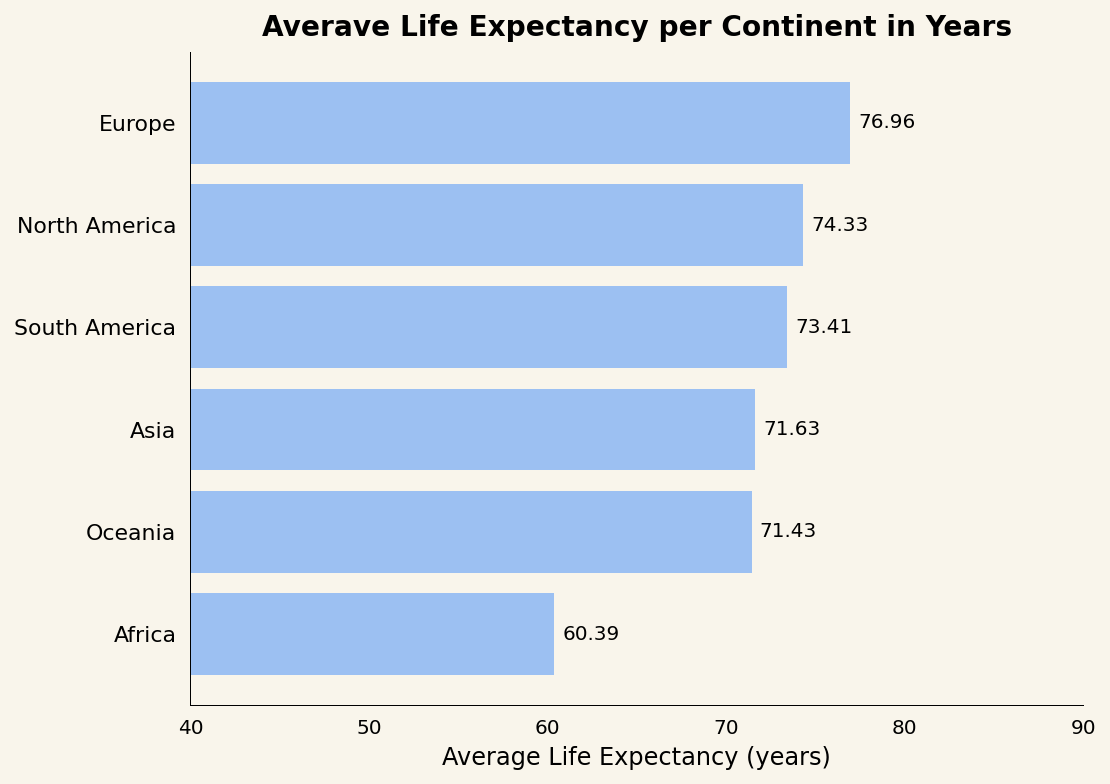

In [16]:
# plot average life expectancy per continent
life_by_continent = df_reg.groupby('continent').mean()['life_expectancy'].sort_values()

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(40, 90)
bh = ax.barh(life_by_continent.index, life_by_continent.values, color='#5F9DF7', alpha=0.6)
ax.bar_label(bh, labels=np.round(life_by_continent.values, 2), fontsize=10, label_type="edge", padding=4)
ax.set_yticks(range(len(life_by_continent.index)))
ax.set_yticklabels(life_by_continent.index, fontsize=11)
ax.set_xlabel('Average Life Expectancy (years)', fontsize=12)
ax.set_title('Averave Life Expectancy per Continent in Years', fontsize=14, fontweight='bold', pad=8)

ax.set_facecolor(color="#F9F5EB")
fig.patch.set_facecolor('#F9F5EB')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
plt.tick_params(axis='x', which='both', bottom=False)
plt.tick_params(axis='y', which='both', left=False)
plt.savefig('images/avg_life_exp_per_continent.jpg', format='jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()

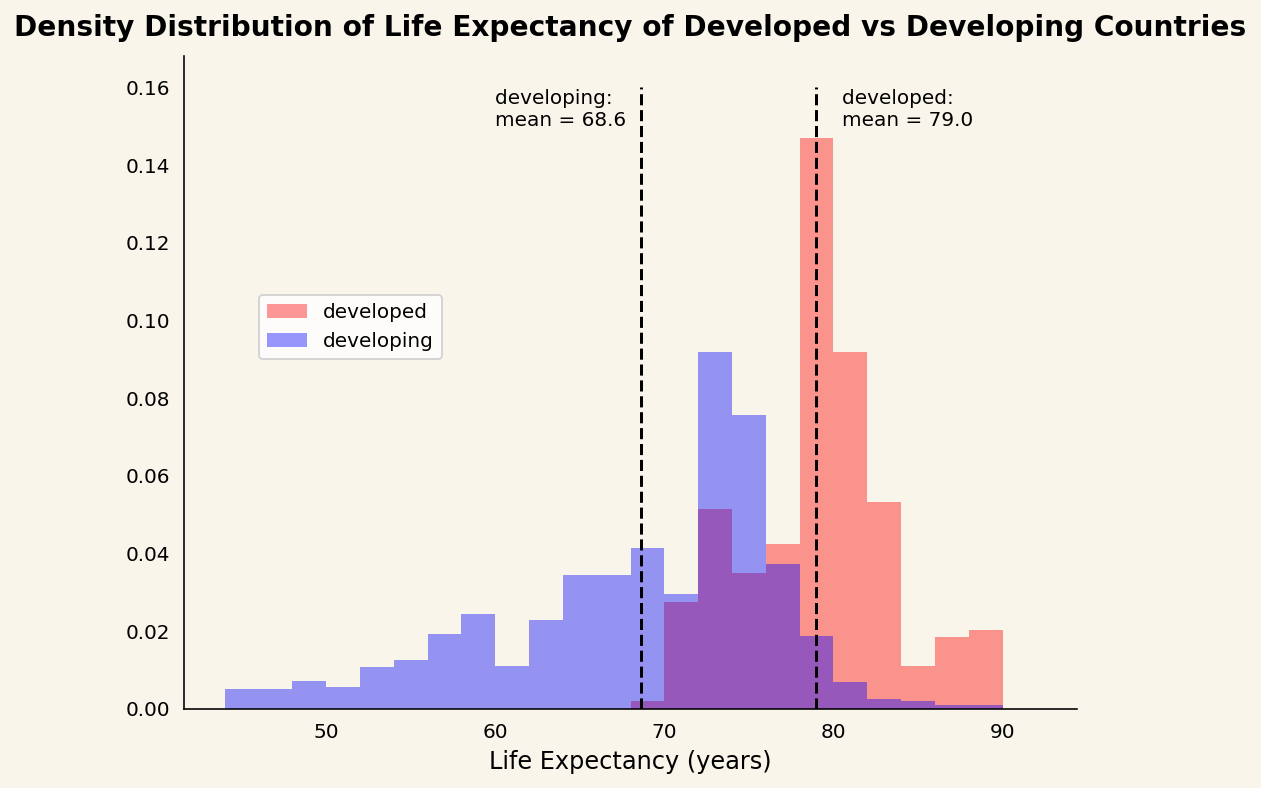

In [17]:
# compare life expectancy distribution of developed and developing country
developed = df_reg[df_reg.developed]['life_expectancy']
developing = df_reg[~df_reg.developed]['life_expectancy']

fig, ax = plt.subplots(figsize=(8, 6))
bins = range(44, 94, 2)
ax.hist(developed.values, bins=bins, density=True, color='r', alpha=0.4, label='developed')
ax.hist(developing.values, bins=bins, density=True, color='b', alpha=0.4, label='developing')

ax.plot([developed.mean()] * 9, np.arange(0, 0.18, 0.02), color='black', linestyle='dashed')
ax.plot([developing.mean()] * 9, np.arange(0, 0.18, 0.02), color='black', linestyle='dashed')
ax.text(60, 0.15, f'developing: \nmean = {round(developing.mean(), 1)}')
ax.text(80.5, 0.15, f'developed: \nmean = {round(developed.mean(), 1)}')

ax.set_xlabel('Life Expectancy (years)', fontsize=12)
ax.set_title('Density Distribution of Life Expectancy of Developed vs Developing Countries', fontsize=14, fontweight='bold', pad=10)

ax.set_facecolor(color="#F9F5EB")
fig.patch.set_facecolor('#F9F5EB')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(bbox_to_anchor=(0.3, 0.65))
plt.tick_params(axis='x', which='both', bottom=False)
plt.tick_params(axis='y', which='both', left=False)
plt.savefig('images/density_dist_of_life_exp_developed_vs_ing.jpg', format='jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()

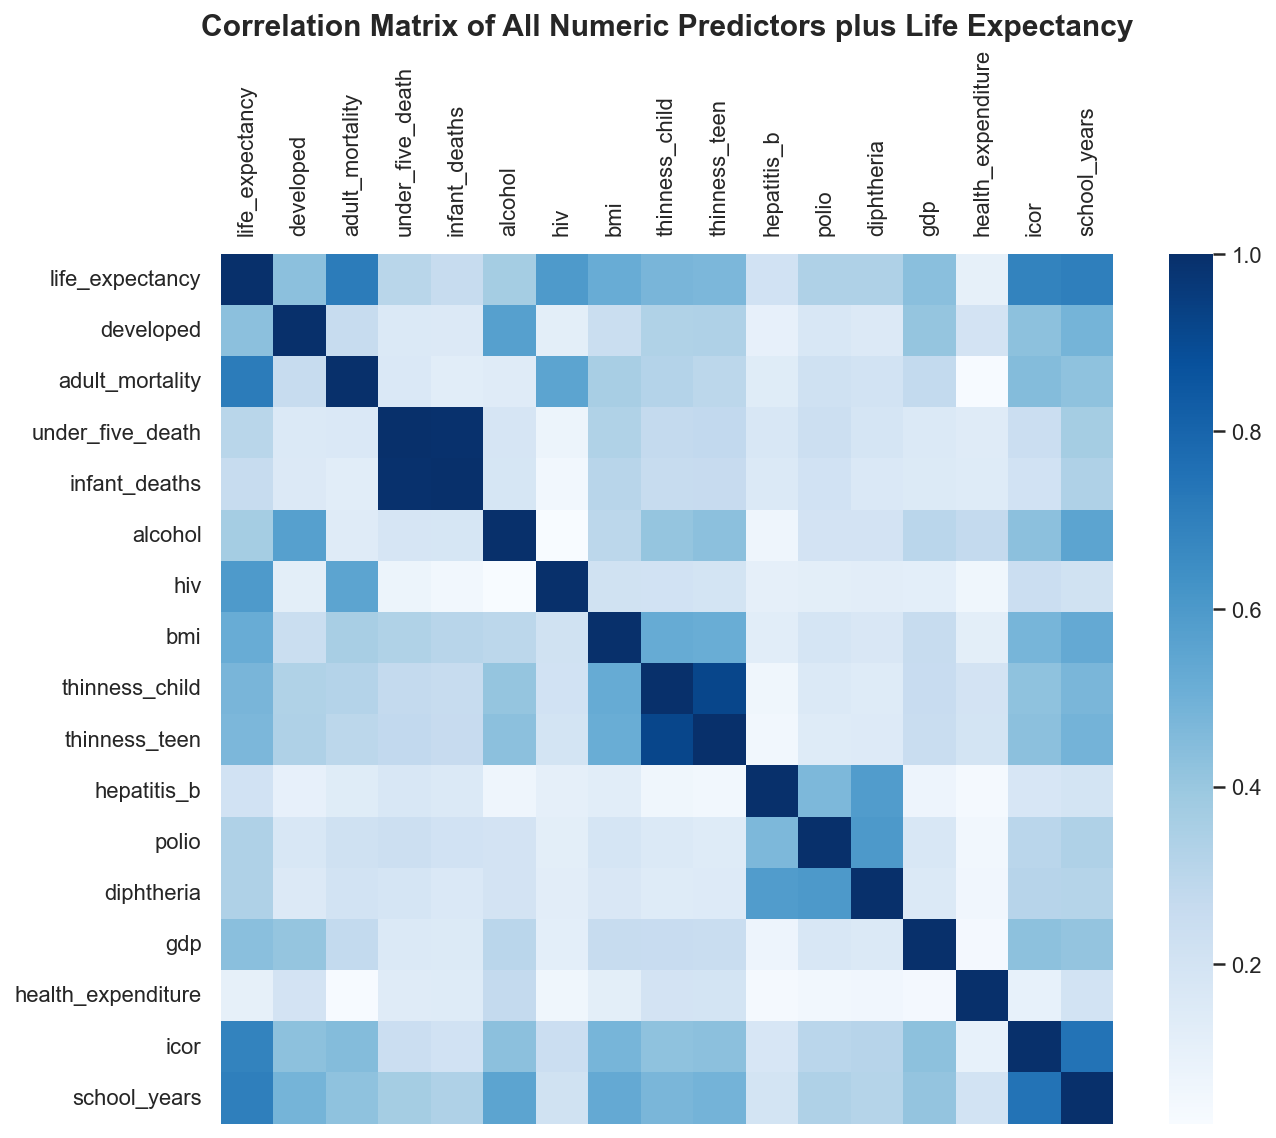

In [18]:
# we suspect that there might be correlation between some predictor columns in the dataset
corr_mat = df_reg.corr()  # correlation matrix
sns.set(rc={'figure.figsize':(10, 8)})
ax = sns.heatmap(np.abs(corr_mat), xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, cmap='Blues')
ax.set_title('Correlation Matrix of All Numeric Predictors plus Life Expectancy', fontsize=15, fontweight='bold')
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='both', top=False)
plt.tick_params(axis='y', which='both', left=False)
plt.savefig('images/corr_matrix_heatmap.jpg', format='jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [19]:
# sort correlation coefficient in descending order
np.abs(corr_mat['life_expectancy']).sort_values(ascending=False)

life_expectancy       1.000000
adult_mortality       0.714858
school_years          0.705308
icor                  0.688267
hiv                   0.595300
bmi                   0.519589
thinness_child        0.478728
thinness_teen         0.471092
gdp                   0.436271
developed             0.430693
alcohol               0.364799
polio                 0.336879
diphtheria            0.334496
under_five_death      0.305002
infant_deaths         0.259027
hepatitis_b           0.210509
health_expenditure    0.107765
Name: life_expectancy, dtype: float64

### Modeling

1. check multicolinearity and influential points using all potential predictors
    - multicolinearity: drop correlated columns, regularization, PCA
    - influential points: parallel analysis
2. fit initial model with all potential predictors
3. using initial model, check model assumption: 
    - heteroscedacity
    - normality
4. model selection
    - t test: locate significant predictors
    - step AIC/BIC
    - R squared/adjusted R squared/Mallow's Cp with best subset
5. final model

In [20]:
df_reg.columns

Index(['life_expectancy', 'continent', 'developed', 'adult_mortality',
       'under_five_death', 'infant_deaths', 'alcohol', 'hiv', 'bmi',
       'thinness_child', 'thinness_teen', 'hepatitis_b', 'polio', 'diphtheria',
       'gdp', 'health_expenditure', 'icor', 'school_years'],
      dtype='object')

In [21]:
# check multicolinearity
init_model = 'life_expectancy ~ continent + developed + adult_mortality + under_five_death \
+ infant_deaths + alcohol + hiv + bmi + thinness_child + thinness_teen + hepatitis_b \
+ polio + diphtheria + gdp + health_expenditure + icor + school_years'

y, X = dmatrices(init_model, data=df_reg, return_type='dataframe')

vif = pd.DataFrame()
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,features,vif
0,Intercept,80.761437
1,continent[T.Asia],2.386897
2,continent[T.Europe],3.863088
3,continent[T.North America],2.006951
4,continent[T.Oceania],1.802028
5,continent[T.South America],1.737861
6,developed[T.True],2.229834
7,adult_mortality,1.893853
8,under_five_death,99.895127
9,infant_deaths,97.822211


`under_five_death` and `infant_deaths` have a significantly large VIF value (>10), which indicates that these two predictors are highly correlated to other predictors, causing multicoliearity. Based on how these two columns are defined (since records in `infant_deaths` are also counted in `under_five_death`), we suspect that they are correlated to each other. We first try to remove `infant_deaths` and see how we improve in multicolinearity. 

In [22]:
remove_infant_deaths = 'life_expectancy ~ continent + developed + adult_mortality + under_five_death \
+ alcohol + hiv + bmi + thinness_child + thinness_teen + hepatitis_b \
+ polio + diphtheria + gdp + health_expenditure + icor + school_years'

y_no_infant, X_no_infant = dmatrices(remove_infant_deaths, data=df_reg, return_type='dataframe')

vif_no_infant = pd.DataFrame()
vif_no_infant['features'] = X_no_infant.columns
vif_no_infant['vif'] = [variance_inflation_factor(X_no_infant.values, i) for i in range(X_no_infant.shape[1])]
vif_no_infant

,features,vif
0,Intercept,77.111919
1,continent[T.Asia],2.181771
2,continent[T.Europe],3.755207
3,continent[T.North America],1.930131
4,continent[T.Oceania],1.749180
5,continent[T.South America],1.669333
6,developed[T.True],2.226108
7,adult_mortality,1.880865
8,under_five_death,1.280095
9,alcohol,2.819463


Now VIF of every predictor is less than 10, and thus, there is no significant multicolinearity now after removing `infant_deaths` from the dataset. Next we check influential points using two methods: 
- externally studentized residual
- cook's distance

In [23]:
curr_model = remove_infant_deaths

# externally studentized residual
lr = smf.ols(curr_model, df_reg).fit()
infl = lr.get_influence()

external_stud_resid = infl.resid_studentized_external
threshold = t.ppf(0.975, df=len(df_reg)-21-1)  # significance level = 0.05

infl_pts_esr = df_reg.index[np.abs(external_stud_resid) > threshold]
print(len(infl_pts_esr))  # by externally studentized residual

108


In [24]:
# cook's distance
cook_dis = infl.summary_frame().cooks_d
infl_pts_cook = df_reg.index[np.abs(cook_dis) >= 4 / len(df_reg)]
print(len(infl_pts_cook))  # by cook's distance

113


In [25]:
# we treat the points that are highlighted by both approaches as influential points
infl_pts_index = list(set(infl_pts_esr).intersection(set(infl_pts_cook)))
print(len(infl_pts_index))

71


Identifying influential points in the original dataset, we do parallel analysis from now on using data with and without these influential points. 

Although it is not required, it is often good practice to normalize all numerical columns (predictors and response) so that the units of all regression coefficients are the same. The statistics test results are often more human-readable with normalization. 

In [26]:
df_stdized = pd.DataFrame()
for col in df_reg.columns:
    if col in ['developed', 'continent']:
        df_stdized[col] = df_reg[col]
        continue
    
    mu = df_reg[col].mean()
    std = df_reg[col].std()
    df_stdized[col] = (df_reg[col] - mu) / std

df_stdized_nofp = df_stdized.drop(index=infl_pts_index)
print(len(df_stdized), len(df_stdized_nofp))

1827 1756


In [27]:
init_lr = smf.ols(curr_model, df_stdized).fit()
init_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     485.6
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:17:45   Log-Likelihood:                -899.34
No. Observations:                1827   AIC:                             1841.
Df Residuals:                    1806   BIC:                             1956.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3655      0.024    -15.109      0.000      -0.413      -0.318
continent[T.Asia]              0.4088      0.031     13.377      0.000       0.349       0.469
continent[T.Europe]            0.4105      0.046      8.901      0.000       0.320       0.501
continent[T.North America]     0.6648      0.039     16.882      0.000       0.588       0.742
continent[T.Oceania]           0.2360      0.047      4.995      0.000       0.143       0.329
continent[T.South America]     0.4758      0.047     10.163      0.000       0.384       0.568
developed[T.True]              0.2652      0.039      6.793      0.000       0.189       0.342
adult_mortality               -0.2309      0.013    -18.068      0.000      -0.256      -0.206
under_five_death              -0.0404      0.011     -3.833      0.000      -0.061      -0.020
alcohol                       -0.0580      0.016     -3.710      0.000      -0.089      -0.027
hiv                           -0.2485      0.012    -20.974      0.000      -0.272      -0.225
bmi                            0.0318      0.013      2.533      0.011       0.007       0.056
thinness_child                -0.0311      0.024     -1.281      0.201      -0.079       0.017
thinness_teen                 -0.0055      0.024     -0.227      0.820      -0.053       0.042
hepatitis_b                   -0.0186      0.012     -1.555      0.120      -0.042       0.005
polio                          0.0318      0.012      2.614      0.009       0.008       0.056
diphtheria                     0.0417      0.013      3.121      0.002       0.015       0.068
gdp                            0.0861      0.011      7.868      0.000       0.065       0.108
health_expenditure             0.0107      0.010      1.060      0.289      -0.009       0.030
icor                           0.1461      0.015      9.532      0.000       0.116       0.176
school_years                   0.2376      0.017     14.004      0.000       0.204       0.271
==============================================================================
Omnibus:                       60.100   Durbin-Watson:                   0.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.717
Skew:                           0.095   Prob(JB):                     1.87e-33
Kurtosis:                       4.394   Cond. No.                         17.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With this initial regression model using all potential predictors, we check model assumptions with the dataset. 
- heteroscedasticity
- normality

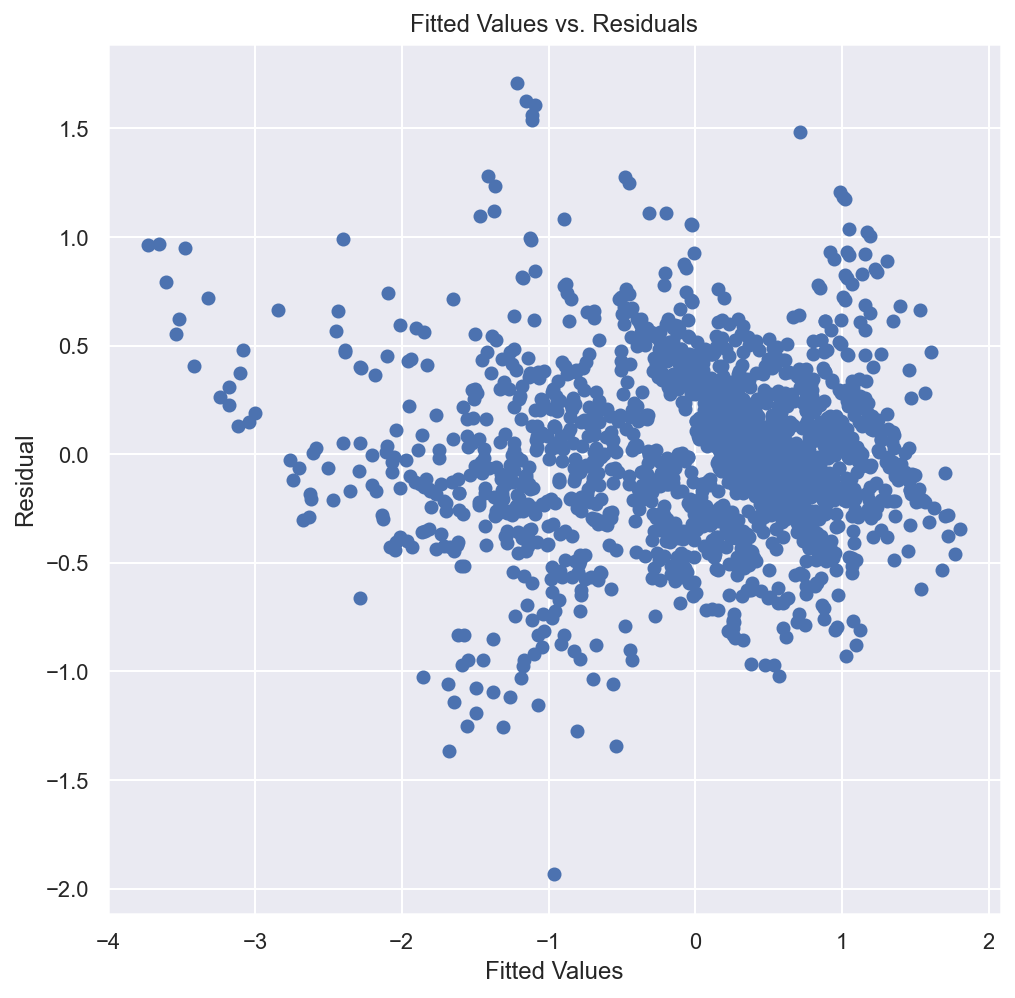

In [28]:
# check heteroscedasticity
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(init_lr.fittedvalues, init_lr.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
plt.savefig('images/init_lr_residual_plot.png', format='png', bbox_inches='tight', pad_inches=0.2)
plt.show()

From the residual plot, we judge that the variance of error is smaller with smaller fitted values, and larger variance as fitted value increases. 

In [29]:
bp_test = het_breuschpagan(init_lr.resid, init_lr.model.exog)
labels = ['BP-test statistic', 'BP-test p-value']
print(dict(zip(labels, bp_test)))

{'BP-test statistic': 257.28108137444383, 'BP-test p-value': 3.872505011695523e-43}


The p value from Breusch-Pagan test < 0.05, confirms our assertion that this initial regression model has significant heteroscedacity, i.e. violation of equal variance. 

To solve this issue, we use robust errors, i.e. Heteroscedasticity-Consistent Standard Error (HCE) instead of original variance from OLSE to perform t tests on significance of predictors. 

In [30]:
# summary of test results using robust errors
curr_lr = init_lr.get_robustcov_results(cov_type="HC0")
curr_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     439.5
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:17:45   Log-Likelihood:                -899.34
No. Observations:                1827   AIC:                             1841.
Df Residuals:                    1806   BIC:                             1956.
Df Model:                          20                                         
Covariance Type:                  HC0                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3655      0.029    -12.767      0.000      -0.422      -0.309
continent[T.Asia]              0.4088      0.034     12.069      0.000       0.342       0.475
continent[T.Europe]            0.4105      0.046      8.967      0.000       0.321       0.500
continent[T.North America]     0.6648      0.043     15.342      0.000       0.580       0.750
continent[T.Oceania]           0.2360      0.050      4.729      0.000       0.138       0.334
continent[T.South America]     0.4758      0.041     11.495      0.000       0.395       0.557
developed[T.True]              0.2652      0.038      7.050      0.000       0.191       0.339
adult_mortality               -0.2309      0.018    -12.964      0.000      -0.266      -0.196
under_five_death              -0.0404      0.011     -3.795      0.000      -0.061      -0.020
alcohol                       -0.0580      0.018     -3.245      0.001      -0.093      -0.023
hiv                           -0.2485      0.017    -14.248      0.000      -0.283      -0.214
bmi                            0.0318      0.012      2.615      0.009       0.008       0.056
thinness_child                -0.0311      0.026     -1.211      0.226      -0.081       0.019
thinness_teen                 -0.0055      0.025     -0.216      0.829      -0.055       0.044
hepatitis_b                   -0.0186      0.012     -1.580      0.114      -0.042       0.004
polio                          0.0318      0.012      2.725      0.006       0.009       0.055
diphtheria                     0.0417      0.014      3.010      0.003       0.015       0.069
gdp                            0.0861      0.010      8.429      0.000       0.066       0.106
health_expenditure             0.0107      0.012      0.919      0.358      -0.012       0.033
icor                           0.1461      0.017      8.402      0.000       0.112       0.180
school_years                   0.2376      0.025      9.540      0.000       0.189       0.286
==============================================================================
Omnibus:                       60.100   Durbin-Watson:                   0.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.717
Skew:                           0.095   Prob(JB):                     1.87e-33
Kurtosis:                       4.394   Cond. No.                         17.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Now we check violation of normality in the dataset using qq-plot and Jarque-Bera test. 

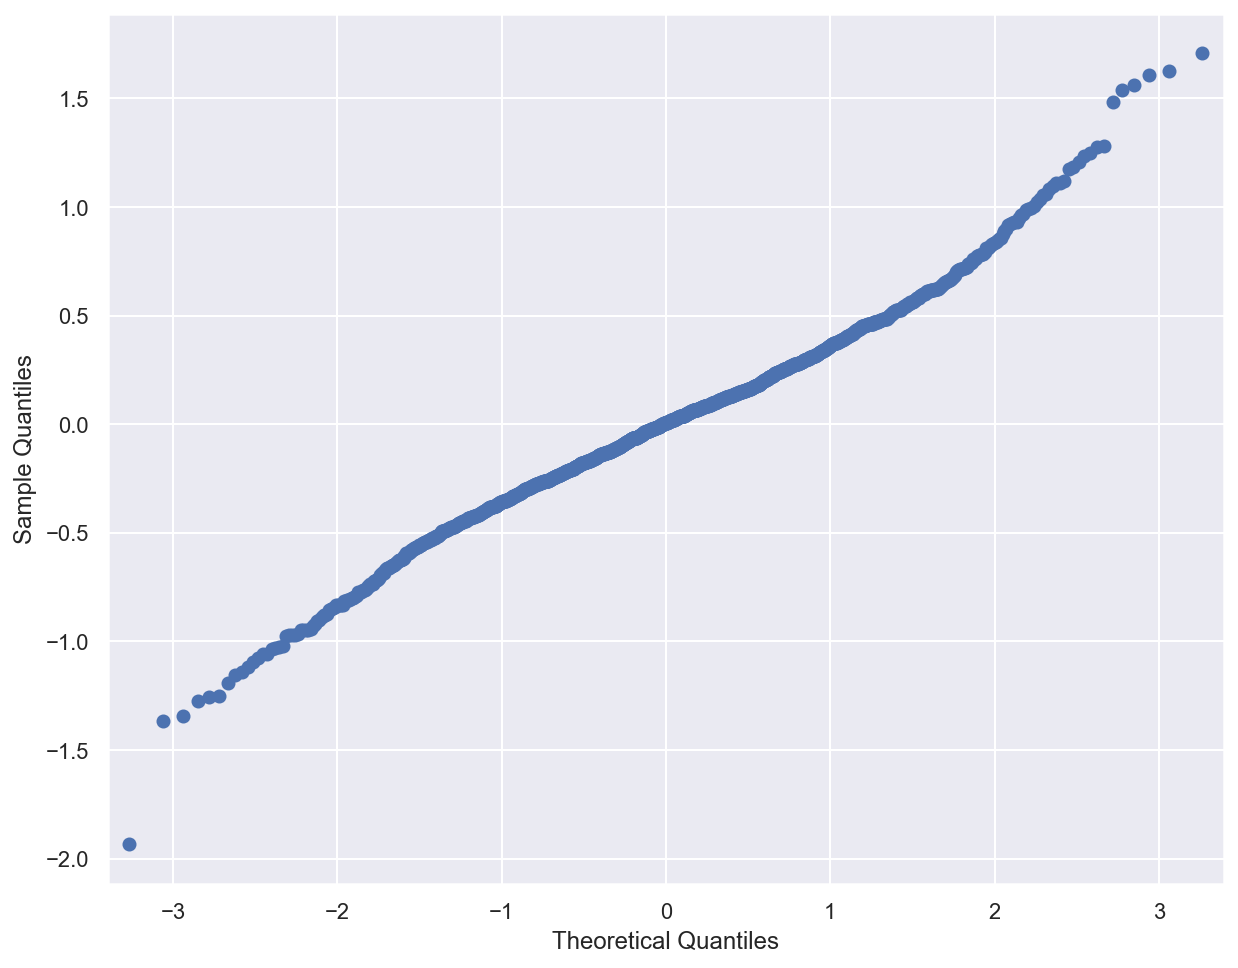

In [31]:
# qq-plot
sm.qqplot(curr_lr.resid)
plt.savefig('images/curr_lr_qq.png', format='png', bbox_inches='tight', pad_inches=0.2)

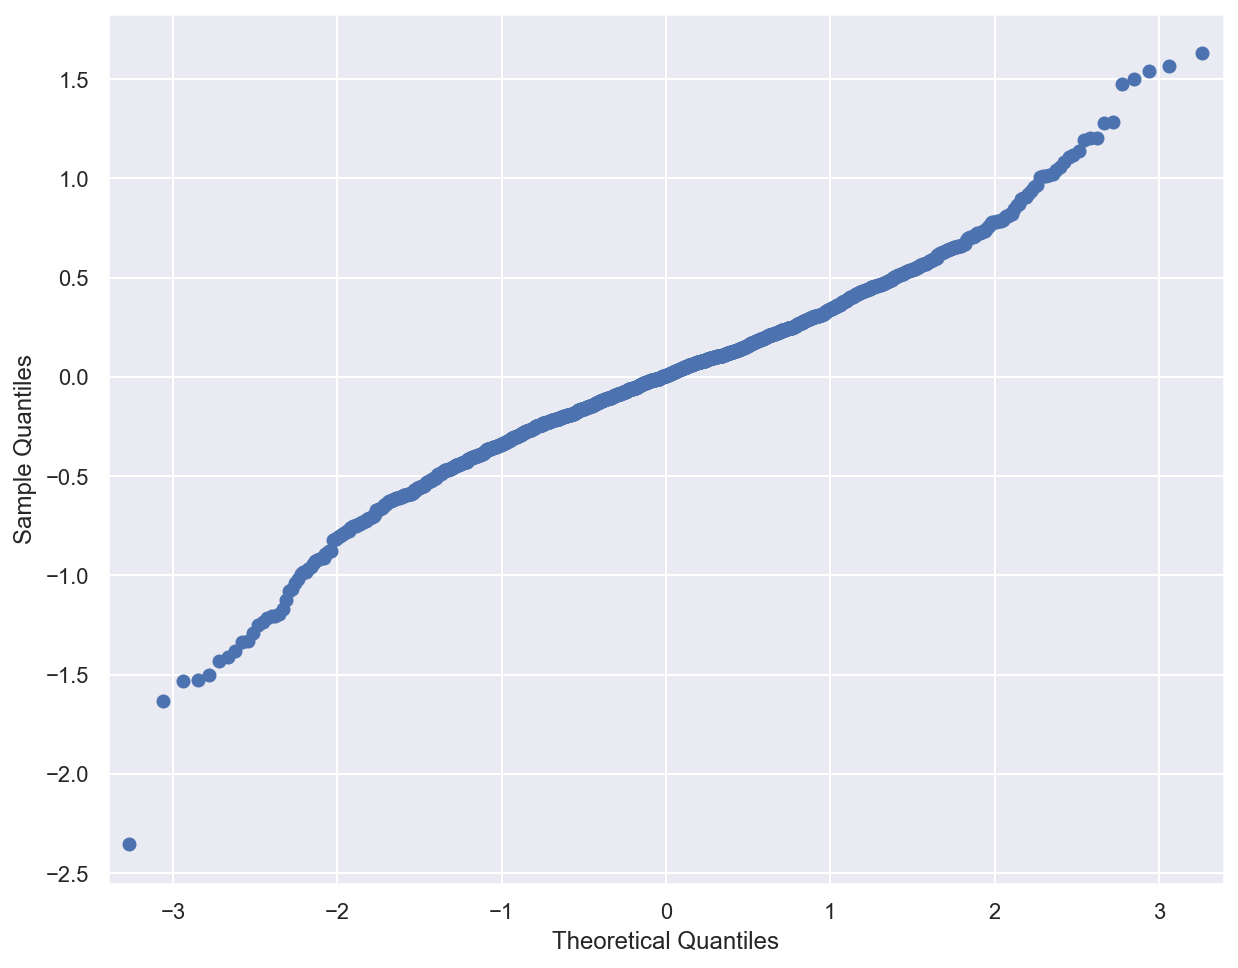

In [32]:
df_copy = df_reg.copy()
df_copy['life_expectancy'] = np.log(df_copy['life_expectancy'])
df_copy_stdized = pd.DataFrame()
for col in df_copy.columns:
    if col in ['developed', 'continent']:
        df_copy_stdized[col] = df_copy[col]
        continue
    
    mu = df_copy[col].mean()
    std = df_copy[col].std()
    df_copy_stdized[col] = (df_copy[col] - mu) / std
    
sm.qqplot(smf.ols(curr_model, df_copy_stdized).fit().get_robustcov_results(cov_type='HC0').resid)
plt.savefig('images/curr_lr_qq_log_trans.png', format='png', bbox_inches='tight', pad_inches=0.2)

Both the summary statistics (skew $\sim$ 0 while a large kurtosis) and the qq-plot of current model indicates the distribution of errors is symmetric with heavier tails than Gaussian, and using log transformation on response variable does not really improve the shape of distribution to Gaussian. 

Alternatively Jarque-Bera test produces a p value = 1.87 * 10^(-33) < 0.05, indicating that there is significant violation of normality in the current linear model. 

Therefore, we try fitting the model without influential points since influential points might be the source of both heteroscedasticity and non-normality. 

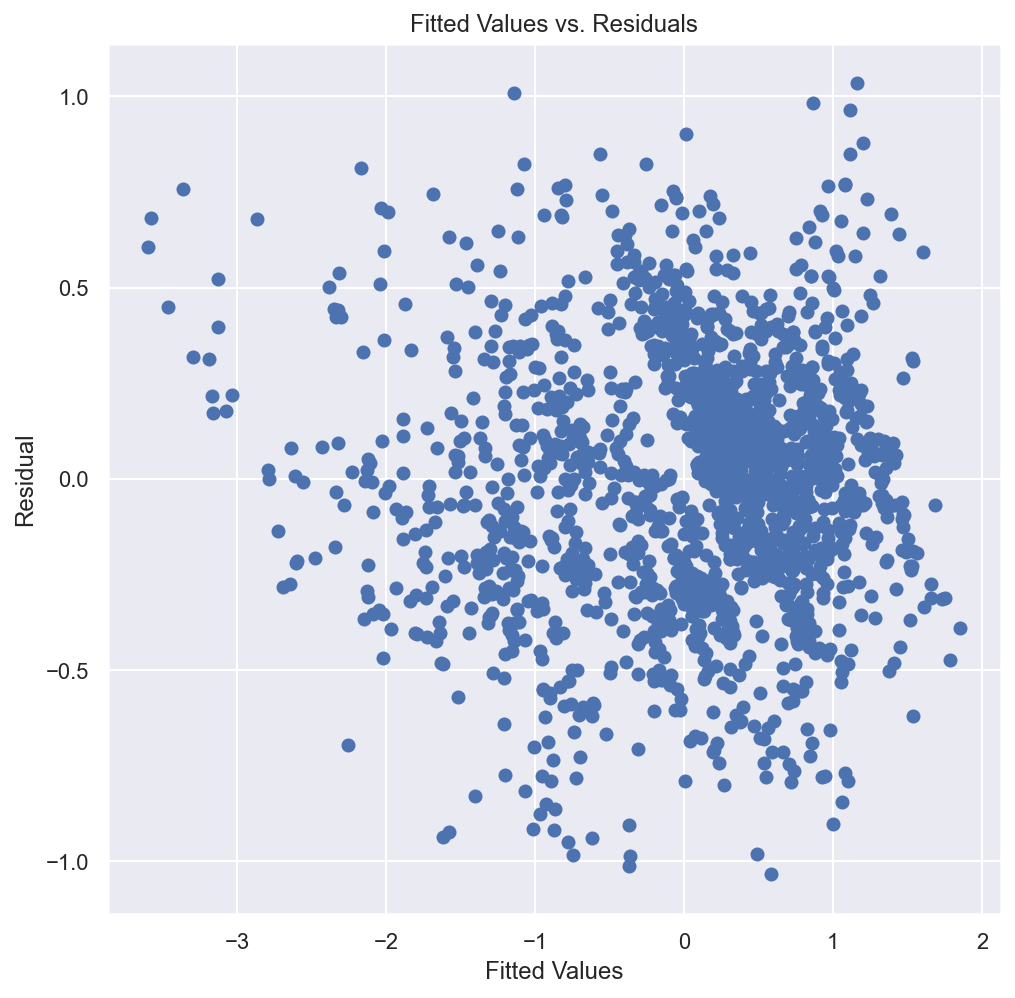

{'BP-test statistic': 155.3923611847227, 'BP-test p-value': 5.800654389502748e-23}


In [33]:
# try modeling without influential points
init_lr_nofp = smf.ols(curr_model, df_stdized_nofp).fit()
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(init_lr_nofp.fittedvalues, init_lr_nofp.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
plt.savefig('images/curr_lr_residual_plot_nofp.png', format='png', bbox_inches='tight', pad_inches=0.2)
plt.show()

bp_test_nofp = het_breuschpagan(init_lr_nofp.resid, init_lr_nofp.model.exog)
print(dict(zip(labels, bp_test_nofp)))

The Breusch-Pagan test is still rejected, suggesting that heteroscedasticity exists. We use robust errors instead to get test results. 

In [34]:
curr_lr_nofp = init_lr_nofp.get_robustcov_results(cov_type='HC0')
curr_lr_nofp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     587.4
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:17:46   Log-Likelihood:                -561.92
No. Observations:                1756   AIC:                             1166.
Df Residuals:                    1735   BIC:                             1281.
Df Model:                          20                                         
Covariance Type:                  HC0                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3115      0.024    -12.823      0.000      -0.359      -0.264
continent[T.Asia]              0.3484      0.029     12.060      0.000       0.292       0.405
continent[T.Europe]            0.3235      0.040      8.067      0.000       0.245       0.402
continent[T.North America]     0.5563      0.035     15.791      0.000       0.487       0.625
continent[T.Oceania]           0.1815      0.044      4.112      0.000       0.095       0.268
continent[T.South America]     0.4077      0.036     11.280      0.000       0.337       0.479
developed[T.True]              0.2291      0.032      7.126      0.000       0.166       0.292
adult_mortality               -0.2490      0.015    -16.635      0.000      -0.278      -0.220
under_five_death              -0.0265      0.009     -2.845      0.004      -0.045      -0.008
alcohol                       -0.0699      0.014     -5.086      0.000      -0.097      -0.043
hiv                           -0.2494      0.014    -18.228      0.000      -0.276      -0.223
bmi                            0.0239      0.010      2.346      0.019       0.004       0.044
thinness_child                -0.0446      0.016     -2.792      0.005      -0.076      -0.013
thinness_teen                  0.0179      0.015      1.212      0.226      -0.011       0.047
hepatitis_b                   -0.0149      0.010     -1.493      0.136      -0.034       0.005
polio                          0.0306      0.011      2.905      0.004       0.010       0.051
diphtheria                     0.0285      0.011      2.495      0.013       0.006       0.051
gdp                            0.0710      0.008      8.488      0.000       0.055       0.087
health_expenditure             0.0371      0.009      4.206      0.000       0.020       0.054
icor                           0.1682      0.016     10.780      0.000       0.138       0.199
school_years                   0.2714      0.016     17.231      0.000       0.241       0.302
==============================================================================
Omnibus:                        3.686   Durbin-Watson:                   0.710
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                3.584
Skew:                          -0.104   Prob(JB):                        0.167
Kurtosis:                       3.076   Cond. No.                         17.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

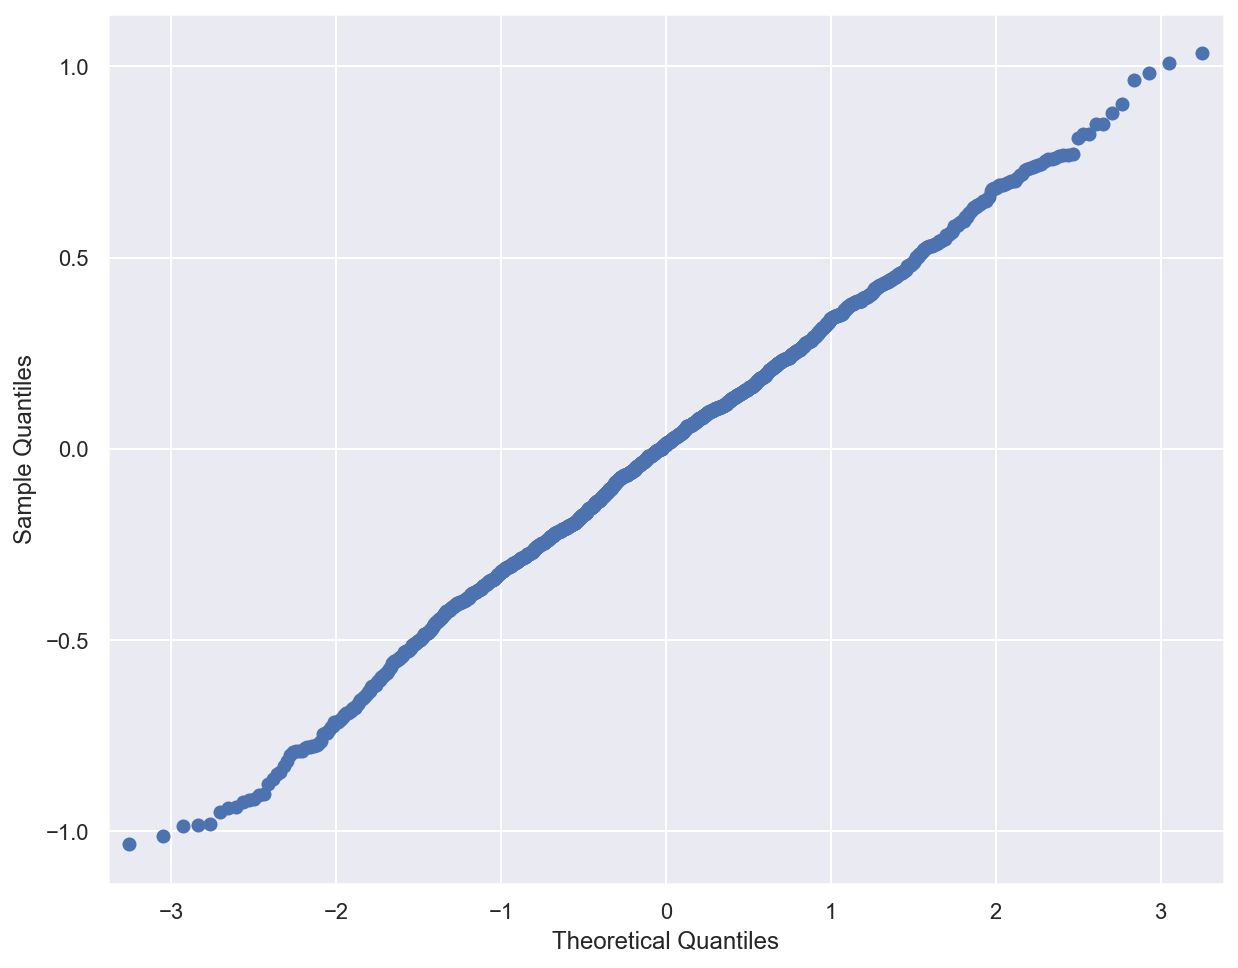

In [35]:
sm.qqplot(curr_lr_nofp.resid)
plt.savefig('images/curr_lr_qq_nofp.png', format='png', bbox_inches='tight', pad_inches=0.2)

Now the curve in qq-plot suggests that we don't have signifant violation of normality, and the JB test of p value being 0.167 is supporting the same statement. Therefore, we shall continue with this model and the dataset excluding influential points. 

### Model Selection

We first take a look at the full model we currently regress:

`life_expectancy` ~ `continent` + `developed` + `adult_mortality` + `under_five_death` + `alcohol` + `hiv` + `bmi` + `thinness_child` + `thinness_teen` + `hepatitis_b` + `polio` + `diphtheria` + `gdp` + `health_expenditure` + `icor` + `school_years`

where `continent` and `developed` are categorical: 
- `continent` contains six categories: `Asia`, `Africa`, `North America`, `South America`, `Europe`, and `Oceania`
- `developed` contains two categories: `True` and `False`

and all other predictors and response variable are numerical.

Additionally, Heteroscedasticity-Consistent Standard Errors are used when regressing this linear model. The summary is as follows:

In [36]:
# summary of current linear model
curr_lr_nofp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     587.4
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:17:46   Log-Likelihood:                -561.92
No. Observations:                1756   AIC:                             1166.
Df Residuals:                    1735   BIC:                             1281.
Df Model:                          20                                         
Covariance Type:                  HC0                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3115      0.024    -12.823      0.000      -0.359      -0.264
continent[T.Asia]              0.3484      0.029     12.060      0.000       0.292       0.405
continent[T.Europe]            0.3235      0.040      8.067      0.000       0.245       0.402
continent[T.North America]     0.5563      0.035     15.791      0.000       0.487       0.625
continent[T.Oceania]           0.1815      0.044      4.112      0.000       0.095       0.268
continent[T.South America]     0.4077      0.036     11.280      0.000       0.337       0.479
developed[T.True]              0.2291      0.032      7.126      0.000       0.166       0.292
adult_mortality               -0.2490      0.015    -16.635      0.000      -0.278      -0.220
under_five_death              -0.0265      0.009     -2.845      0.004      -0.045      -0.008
alcohol                       -0.0699      0.014     -5.086      0.000      -0.097      -0.043
hiv                           -0.2494      0.014    -18.228      0.000      -0.276      -0.223
bmi                            0.0239      0.010      2.346      0.019       0.004       0.044
thinness_child                -0.0446      0.016     -2.792      0.005      -0.076      -0.013
thinness_teen                  0.0179      0.015      1.212      0.226      -0.011       0.047
hepatitis_b                   -0.0149      0.010     -1.493      0.136      -0.034       0.005
polio                          0.0306      0.011      2.905      0.004       0.010       0.051
diphtheria                     0.0285      0.011      2.495      0.013       0.006       0.051
gdp                            0.0710      0.008      8.488      0.000       0.055       0.087
health_expenditure             0.0371      0.009      4.206      0.000       0.020       0.054
icor                           0.1682      0.016     10.780      0.000       0.138       0.199
school_years                   0.2714      0.016     17.231      0.000       0.241       0.302
==============================================================================
Omnibus:                        3.686   Durbin-Watson:                   0.710
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                3.584
Skew:                          -0.104   Prob(JB):                        0.167
Kurtosis:                       3.076   Cond. No.                         17.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

First approach for feature selection is review t test results to determine which predictors are significant to y. 

p value of each of these following predictors > 0.05: 
- `thinness_teen`
- `hepatitis_b`

Therefore, from the perspective of t test results, we should consider remove these predictors from current model such that all remaining predictors are statistically significant to `life_expectancy`, i.e. the model using t test results for feature selection is: 

`life_expectancy` ~ `continent` + `developed` + `adult_mortality` + `under_five_death` + `alcohol` + `hiv` + `bmi` + `thinness_child` + `polio` + `diphtheria` + `gdp` + `health_expenditure` + `icor` + `school_years`
.

Using this model as a baseline, we compare adjusted R squared values and Mallow's Cp among all models with 14 predictors or more. 

In [37]:
def mallows_cp(reduced_model, full_model, p, n):
    """
    Computes Mallow's Cp for the reduced model using full model as a reference.
    """
    SSE_reduced = reduced_model.mse_resid * (n - p)
    MSE_full = full_model.mse_resid

    Cp = SSE_reduced / MSE_full - (n - 2 * p)
    return Cp

In [38]:
candidates = ['life_expectancy ~ continent + developed \
+ adult_mortality + under_five_death + alcohol + hiv + bmi \
+ thinness_child + polio + diphtheria + gdp + health_expenditure \
+ icor + school_years',
            'life_expectancy ~ continent + developed \
+ adult_mortality + under_five_death + alcohol + hiv + bmi \
+ thinness_child + thinness_teen + polio + diphtheria + gdp \
+ health_expenditure + icor + school_years', 
            'life_expectancy ~ continent + developed \
+ adult_mortality + under_five_death + alcohol + hiv + bmi \
+ thinness_child + hepatitis_b + polio + diphtheria + gdp \
+ health_expenditure + icor + school_years', 
             'life_expectancy ~ continent + developed \
+ adult_mortality + under_five_death + alcohol + hiv + bmi \
+ thinness_child + thinness_teen + hepatitis_b + polio \
+ diphtheria + gdp + health_expenditure + icor + school_years']

candidate_refs = ['excluding both', 'excluding hepatitis_b', 'excluding thinness_teen', 'full model']

full = curr_lr_nofp

adj_r2_ls = []
mallows_cp_ls = []
ps = []
for candidate in candidates:
    reduced = smf.ols(candidate, df_stdized_nofp).fit().get_robustcov_results(cov_type='HC0')
    adj_r2_ls.append(reduced.rsquared_adj)
    ps.append(len(reduced.params))
    mallows_cp_ls.append(mallows_cp(reduced, full, len(reduced.params), len(df_stdized_nofp)))

table = pd.DataFrame(list(zip(candidate_refs, adj_r2_ls, mallows_cp_ls, ps)), columns=['candidate_model', 'adj_r_squared', 'mallows_cp', 'p'])
table

,candidate_model,adj_r_squared,mallows_cp,p
0,excluding both,0.876100,19.751772,19
1,excluding hepatitis_b,0.876076,21.096502,20
2,excluding thinness_teen,0.876175,19.706209,20
3,full model,0.876154,21.000000,21


For p = 19, Mallow's Cp is 19.75 which is reasonably close to 19, so the model excluding both `thinness_teen` and `hepatitis_b` should be included into consideration. 

For p = 20, minimal Mallow's Cp is 19.71 which is also reasonably close to 20, so the model excluding only `thinness_teen` should also be considered. 

On the other hand, the model excluding only `thinness_teen` has the highest adjusted R squared value among 4. Therefore, in summary, our candidate pool now has two models: 
- model excluding both `thinness_teen` and `hepatitis_b`
- model excluding only `thinness_teen`

We then calculate AIC and BIC values for both models and pick the final decision. 

In [39]:
model_short = smf.ols(candidates[0], df_stdized_nofp).fit().get_robustcov_results(cov_type='HC0')
model_long = smf.ols(candidates[2], df_stdized_nofp).fit().get_robustcov_results(cov_type='HC0')

aic_bic = pd.DataFrame([[candidate_refs[0], model_short.aic, model_short.bic],
                        [candidate_refs[2], model_long.aic, model_long.bic]],
                       columns=['model', 'AIC', 'BIC'])
aic_bic

,model,AIC,BIC
0,excluding both,1164.622786,1268.567868
1,excluding thinness_teen,1164.554525,1273.970401


Model excluding only `thinness_teen` has a slightly lower AIC while model excluding both `thinness_teen` and `hepatitis_b` has a lower BIC. When the conclusion using AIC does not agree with BIC, we, in practice, favor BIC over AIC and thus, pick 

`life_expectancy` ~ `continent` + `developed` + `adult_mortality` + `under_five_death` + `alcohol` + `hiv` + `bmi` + `thinness_child` + `polio` + `diphtheria` + `gdp` + `health_expenditure` + `icor` + `school_years`

as our final model.


One alternative approach for feature selection is stepwise AIC/BIC. Implementing the backward stepwise algorithm, we start with the full model, i.e. the model with all 16 predictors in `curr_lr_nofp`. We then attempt to remove predictors one by one to decrease AIC/BIC as large as possible, and stop when removing any predictor in current model could not decrease AIC/BIC value. We choose to evaluate BIC values when implementing stepwise AIC/BIC. 

In [40]:
def backward_step_BIC(df, full_model, verbose=True):
    """
    Implements backward stepwise BIC algorithm to find the best model with lowest BIC. 
    Returns the optimal model using backward stepwise BIC. 
    """
    
    y = full_model.split('~')[0].strip()
    X = [col.strip() for col in full_model.split('~')[1].strip().split('+')]
    
    # check if all columns in X are valid columns in df
    if not set(X).issubset(set(df.columns)):
        print('Invalid predictor provided.')
        return
    
    if y not in df.columns:
        print('Invalid response variable provided.')
        return
    
    # fit the full model with robust errors and get BIC of full model
    full = smf.ols(full_model, df).fit().get_robustcov_results(cov_type='HC0')
    min_bic = (full_model, full.bic)
    
    if verbose:
        print('Starting point: full model')
        print(f'Full model: {full_model}')
        print(f'Number of parameters: {len(full.params)}')
        print(f'Full model BIC: {full.bic}')
        print('')

    # stepwise regression
    predictors = X.copy()
    prev_bic = min_bic[1]  # keep track of lowest bic of last iteration
    iter = 1
    while predictors:
        for i, predictor in enumerate(predictors):
            model = f'{y} ~ ' + ' + '.join([predictors[j] for j in range(len(predictors)) if j != i])
            reduced = smf.ols(model, df).fit().get_robustcov_results(cov_type='HC0')
            bic = reduced.bic
            if bic < min_bic[1]:
                min_bic = (model, bic)
                removed = predictors[i]
        
        if min_bic[1] == prev_bic:
            break
        
        predictors = [col.strip() for col in min_bic[0].split('~')[1].strip().split('+')]
        prev_bic = min_bic[1]
        
        if verbose:
            print(f'Iteration {iter}')
            print(f'Removed: {removed}')
            print(f'Current model: {min_bic[0]}')
            print(f'Number of paramaters: {len(smf.ols(model, df).fit().get_robustcov_results(cov_type="HC0").params)}')
            print(f'Current model BIC: {min_bic[1]}')
            print('')
        
        iter += 1
        
    return min_bic
        
    

In [41]:
optimal_bic = backward_step_BIC(df_stdized_nofp, curr_model, verbose=True)
optimal_bic

Starting point: full model
Full model: life_expectancy ~ continent + developed + adult_mortality + under_five_death + alcohol + hiv + bmi + thinness_child + thinness_teen + hepatitis_b + polio + diphtheria + gdp + health_expenditure + icor + school_years
Number of parameters: 21
Full model BIC: 1280.7265833625602

Iteration 1
Removed: thinness_teen
Current model: life_expectancy ~ continent + developed + adult_mortality + under_five_death + alcohol + hiv + bmi + thinness_child + hepatitis_b + polio + diphtheria + gdp + health_expenditure + icor + school_years
Number of paramaters: 20
Current model BIC: 1273.97040079515

Iteration 2
Removed: hepatitis_b
Current model: life_expectancy ~ continent + developed + adult_mortality + under_five_death + alcohol + hiv + bmi + thinness_child + polio + diphtheria + gdp + health_expenditure + icor + school_years
Number of paramaters: 19
Current model BIC: 1268.5678678217955

Iteration 3
Removed: diphtheria
Current model: life_expectancy ~ continent

('life_expectancy ~ continent + developed + adult_mortality + under_five_death + alcohol + hiv + thinness_child + polio + gdp + health_expenditure + icor + school_years',
 1262.0001080104446)

Using stepwise BIC method, we get the optimal model: 

`life_expectancy` ~ `continent` + `developed` + `adult_mortality` + `under_five_death` + `alcohol` + `hiv` + `thinness_child` + `polio` + `gdp` + `health_expenditure` + `icor` + `school_years`
. 

This optimal model is different from what we decide using t test results:

`life_expectancy` ~ `continent` + `developed` + `adult_mortality` + `under_five_death` + `alcohol` + `hiv` + `bmi` + `thinness_child` + `polio` + `diphtheria` + `gdp` + `health_expenditure` + `icor` + `school_years`
. 

To decide a better model, we implement ten-fold cross validation on each model and compare their prediction performance on unseen datasets.

In [46]:
def n_fold_cv(df, model, n=10):
    """
    Performs a n-fold cross validation with the dataset df fitting the model 
    using total mean squared residuals. Default value of n is 10.
    
    Returns the total root-mean-square errors of all folds.
    """
    
    np.random.seed(42)
    
    # shuffle the dataset
    data = df.to_numpy()
    np.random.shuffle(data)
    df_shuffled = pd.DataFrame(data, columns=df.columns)

    each_len = int(np.floor(len(df_shuffled) / n))
    tests = []
    trains = []
    for i in range(10):
        if i < 9:
            tests.append(df.iloc[(i*each_len):((i+1)*each_len), :])
            trains.append(pd.concat([df.iloc[:(i*each_len), :], df.iloc[(i+1)*each_len:, :]]))
        else:
            tests.append(df.iloc[(i*each_len):, :])
            trains.append(df.iloc[:(i*each_len), :])
    
    total_rmse = 0
    for train, test in zip(trains, tests):
        lr = smf.ols(model, train).fit().get_robustcov_results(cov_type='HC0')
        total_rmse += np.sqrt(np.sum(lr.resid ** 2) / len(df))  # root-mean-square error of model in this fold
    
    return total_rmse

In [48]:
model1 = candidates[0]
model2 = optimal_bic[0]
n = 10

print(f'{n}-fold cross validation:')
print(f'Total root-mean-square errors (first approach): {n_fold_cv(df_stdized_nofp, model1, n)}')
print(f'Total root-mean-square errors (second approach): {n_fold_cv(df_stdized_nofp, model2, n)}')

10-fold cross validation:
Total root-mean-square errors (first approach): 3.1511667391862903
Total root-mean-square errors (second approach): 3.1592307440989567


model1 has a smaller total RMSE, indicating that we would choose model1: 

`life_expectancy` ~ `continent` + `developed` + `adult_mortality` + `under_five_death` + `alcohol` + `hiv` + `bmi` + `thinness_child` + `polio` + `diphtheria` + `gdp` + `health_expenditure` + `icor` + `school_years`

as our final choice of model that best describes between the nationwide life expectancy and factors listed above, with the coefficients (and other statistics):

In [44]:
final_lr = smf.ols(model1, df_stdized_nofp).fit().get_robustcov_results(cov_type='HC0')
final_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     650.8
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        12:17:47   Log-Likelihood:                -563.31
No. Observations:                1756   AIC:                             1165.
Df Residuals:                    1737   BIC:                             1269.
Df Model:                          18                                         
Covariance Type:                  HC0                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3110      0.024    -12.814      0.000      -0.359      -0.263
continent[T.Asia]              0.3464      0.029     12.003      0.000       0.290       0.403
continent[T.Europe]            0.3271      0.040      8.201      0.000       0.249       0.405
continent[T.North America]     0.5564      0.035     15.845      0.000       0.488       0.625
continent[T.Oceania]           0.1816      0.044      4.134      0.000       0.095       0.268
continent[T.South America]     0.4067      0.036     11.272      0.000       0.336       0.478
developed[T.True]              0.2258      0.032      7.013      0.000       0.163       0.289
adult_mortality               -0.2499      0.015    -16.678      0.000      -0.279      -0.221
under_five_death              -0.0255      0.009     -2.695      0.007      -0.044      -0.007
alcohol                       -0.0703      0.014     -5.126      0.000      -0.097      -0.043
hiv                           -0.2484      0.014    -18.077      0.000      -0.275      -0.221
bmi                            0.0228      0.010      2.247      0.025       0.003       0.043
thinness_child                -0.0296      0.012     -2.431      0.015      -0.053      -0.006
polio                          0.0289      0.010      2.762      0.006       0.008       0.049
diphtheria                     0.0208      0.010      2.110      0.035       0.001       0.040
gdp                            0.0719      0.008      8.558      0.000       0.055       0.088
health_expenditure             0.0367      0.009      4.157      0.000       0.019       0.054
icor                           0.1681      0.016     10.793      0.000       0.138       0.199
school_years                   0.2704      0.016     17.190      0.000       0.240       0.301
==============================================================================
Omnibus:                        4.091   Durbin-Watson:                   0.708
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                3.989
Skew:                          -0.107   Prob(JB):                        0.136
Kurtosis:                       3.093   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""